La fraude en ligne est une préoccupation majeure pour toutes les entreprises qui gèrent
 des paiements numériques, car elle entraîne des pertes financières importantes et diminue la confiance des clients. Dans le cadre
 de ce projet nous souhaitons développer des modèles de machines learning fiables qui identifient les transactions à partir de vastes ensembles
 de données transactionnelles et comportementales et des informations sur les appareils utilisés. Nous avons un problème de classification
 binaire avec un fort déséquilibre. Dans un premier temps nous allons explorer les données et essaierons de trouver des informations précieuses 
 avant de passser au modèle.
 

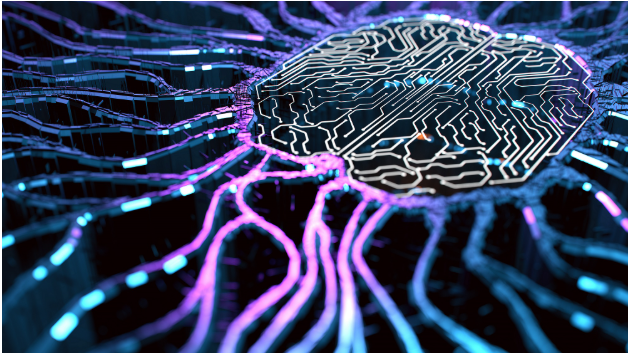

In [1]:
!pip install -U vega_datasets notebook vega > nul 2>&1

In [2]:
#!pip install hyperopt

In [3]:
#!pip install optuna

In [45]:
!pip install openpyxl


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 250.9/250.9 kB 1.5 MB/s eta 0:00:00


In [4]:
%%capture
!pip install lightgbm xgboost catboost shap eli5 networkx

In [5]:
!pip install --upgrade lightgbm


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install -U xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
pip install -U lightgbm


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Packages

In [1]:
from sklearn.preprocessing import OrdinalEncoder
from pathlib import Path
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
#from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot
import gc
import altair as alt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
import optuna
from lightgbm import LGBMClassifier, early_stopping
from xgboost.callback import EarlyStopping
import xgboost as xgb
import pickle

Les données sont séparées en deux bases. Une des bases donne des informations sur les transactions et l'autre base sur l'identité des clients.

## Importations des données

In [2]:
#Importation des données
# Return a new path pointing to the current working directory
HOME_DIR = Path.cwd()

# create a variable for data directory
DATA_DIR = Path(HOME_DIR, "data")

print(f"Work directory: {HOME_DIR} \nData directory: {DATA_DIR}")

Work directory: C:\Users\FALLOU NGOM\Desktop\ISE2\ISE2_sencod_semestre\Machine_learning_2\TP2 
Data directory: C:\Users\FALLOU NGOM\Desktop\ISE2\ISE2_sencod_semestre\Machine_learning_2\TP2\data


In [3]:
train_transaction = pd.read_csv(Path(DATA_DIR, "train_transaction.csv"), sep=",")
train_transaction.shape

(590540, 394)

In [4]:
print(train_transaction["card4"].unique)

<bound method Series.unique of 0           discover
1         mastercard
2               visa
3         mastercard
4         mastercard
             ...    
590535          visa
590536    mastercard
590537    mastercard
590538    mastercard
590539    mastercard
Name: card4, Length: 590540, dtype: object>


In [ ]:
train_identity = pd.read_csv(Path(DATA_DIR, "train_identity.csv"), sep=",")
train_identity.shape

In [ ]:
test_identity = pd.read_csv(Path(DATA_DIR, "test_identity.csv"), sep=",")
test_identity.shape

In [ ]:
test_transaction = pd.read_csv(Path(DATA_DIR, "test_transaction.csv"), sep=",")
test_transaction.shape

Toutes les transactions ne sont pas dans la base identité. Nous allons  conserver toutes les transactions et merger 
avec la base identité. Les transactions qui ne sont pas dans la base identité auront des valeurs NAN. 

In [ ]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [ ]:
test.head()

In [ ]:
del train_identity, train_transaction, test_identity, test_transaction

In [ ]:
print(f'Nous avons {train.isnull().any().sum()} colonnes qui contiennent de valeurs manquantes dans la base train.')
print(f'Nous avons {test.isnull().any().sum()} colonnes qui contiennent de valeurs manquantes dans la base test.')

In [ ]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

In [ ]:
print(f'Nous avons {len(one_value_cols)} colonne dans la base train avec 1 valeur.')
print(f'Nous avons {len(one_value_cols_test)} colonne dans la base test avec 1 valeur.')

Il y a beaucoup de colonnes avec des valeurs manquantes. Une colonne dans la base test avec une seule valeur. 
Dans la suite nous allons explorer d'avantage les données

# Exploration des données

## Variable dépendante

In [ ]:
# Compter les valeurs de isFraud et calculer les proportions
fraud_counts = train['isFraud'].value_counts(normalize=True)

# Création du camembert
labels = ['Non Fraudulent (0)', 'Fraudulent (1)']
colors = ['#66b3ff', '#ff6666']  # Couleurs personnalisées
explode = (0, 0.1)  # Met en évidence la partie "fraude"

plt.figure(figsize=(6,6))
plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors, explode=explode, shadow=True)

plt.title('Répartition des transactions frauduleuses')
plt.axis('equal')  # Rend le cercle circulaire
plt.show()

Plus de 96,5% des données sont des données des non frauduleux. Nous pouvons penser à rééquilibrer lors de la modélisation

## Variable indépendantes

Nous pouvons commencer par les informations d'identité. id_01-id_11 sont des variables continues. id_12-id_38 sont des varia
bles catégorielles aussi. Les deux dernières colonnes sont aussi catégorielles.

In [ ]:
plt.hist(train['id_01']);
plt.title('Distribution de la variable id_01 ');

id_01 prend des valeurs négatives. Nous remarquons aussi une forte présence des valeurs proches de 0.

In [ ]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

id_03 a 88,76% de valeurs manquantes. Plus de 98% des valeurs sont soit manquantes soit égal à 0.

In [ ]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

22% des valeurs de id_11 sont égales à 100 et plus de 76% sont des valeurs manquantes.

In [ ]:
plt.hist(train['id_07']);
plt.title('Distribution de la variable id_07');

La variable semble suivre une distribution normale

In [ ]:
charts = {}
features = ['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
            'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

for i in features:
    feature_count = train[i].value_counts(dropna=False).reset_index()
    feature_count.columns = [i, f'count_{i}']  # éviter la collision de noms
    
    chart = alt.Chart(feature_count).mark_bar().encode(
        y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
        x=alt.X(f'count_{i}:Q', axis=alt.Axis(title='Count')),
        tooltip=[i, f'count_{i}']
    ).properties(title=f"Counts of {i}", width=400)
    
    charts[i] = chart

# Affichage avec Altair (dans un Jupyter Notebook par exemple)
display(
    (charts['id_12'] | charts['id_15'] | charts['id_16']) &
    (charts['id_28'] | charts['id_29'] | charts['id_32']) &
    (charts['id_34'] | charts['id_35'] | charts['id_36']) &
    (charts['id_37'] | charts['id_38'])
)

Nous remarquons que pour toutes ces variables il y a la présence de beaucoup de données manquantes. Nous remarquons aussi
la présence de beaucoup de variable dichotomique avec comme modalité found, not found ou oui ou non

In [ ]:
charts = {}
for i in ['id_30', 'id_31', 'id_33', 'DeviceType', 'DeviceInfo']:
    feature_count = train[i].value_counts(dropna=False)[:40].reset_index()
    feature_count.columns = [i, f'count_{i}']  # nom unique pour chaque "count"
    
    chart = alt.Chart(feature_count).mark_bar().encode(
        x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
        y=alt.Y(f'count_{i}:Q', axis=alt.Axis(title='Count')),
        tooltip=[i, f'count_{i}']
    ).properties(title=f"Counts of {i}", width=800)
    
    charts[i] = chart

# Affichage
display(charts['id_30'] & charts['id_31'] & charts['id_33'] & charts['DeviceType'] & charts['DeviceInfo'])

Ici, nous pouvons avoir quelques informations sur les appareils des clients. Il se pourait que les appareils utilisés soient 
anciennes et que dans les données tests ces appareils n'y figurent plus.

In [ ]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution de la date des transactions');

Les dates des transactions pour les données train et test ne se chevauchent pas. Donc pour la validation il serait judicieux
d'utiliser une séparation basée sur le temps. Pour ne pas entrainer les données sur du futur

In [ ]:
charts = {}
features = ['ProductCD', 'card4', 'card6', 'M4', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

for i in features:
    feature_count = train[i].value_counts(dropna=False).reset_index()
    feature_count.columns = [i, f'count_{i}']  # nom unique pour chaque colonne de comptage
    
    chart = alt.Chart(feature_count).mark_bar().encode(
        y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
        x=alt.X(f'count_{i}:Q', axis=alt.Axis(title='Count')),
        tooltip=[i, f'count_{i}']
    ).properties(title=f"Counts of {i}", width=400)
    
    charts[i] = chart

# Affichage en grille avec Altair
display(
    (charts['ProductCD'] | charts['card4']) &
    (charts['card6'] | charts['M4']) &
    (charts['M1'] | charts['M2']) &
    (charts['M3'] | charts['M5']) &
    (charts['M6'] | charts['M7']) &
    (charts['M8'] | charts['M9'])
)


On a des informations sur les cartes.

In [ ]:
charts = {}
features = ['P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']

for i in features:
    feature_count = train[i].value_counts(dropna=False).reset_index()[:40]
    feature_count.columns = [i, f'count_{i}']  # colonne count renommée
    
    chart = alt.Chart(feature_count).mark_bar().encode(
        x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
        y=alt.Y(f'count_{i}:Q', axis=alt.Axis(title='Count')),
        tooltip=[i, f'count_{i}']
    ).properties(title=f"Counts of {i}", width=600)
    
    charts[i] = chart

# Affichage des graphiques combinés
display(
    (charts['P_emaildomain'] | charts['R_emaildomain']) &
    (charts['card1'] | charts['card2']) &
    (charts['card3'] | charts['card5']) &
    (charts['addr1'] | charts['addr2'])
)

Nous remarquons qu'il y a des répétitions des données. Par exemple gmail.com et gmail sont une même observations.

# Feature engineering

In [ ]:
test.columns = test.columns.str.replace("-", "_")

On harmonise les données

In [ ]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('std')

In [ ]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

On sépare les observations à partir du point. Par exemple google.com est google à part et com à part

# Preparation des données

In [ ]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

In [ ]:
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [ ]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols+ one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

In [ ]:
with open('./Api/2.Deployment/Mappings/drop_features.pkl', 'wb') as f:
    pickle.dump(cols_to_drop, f)

On supprime les colonnes qui contiennent plus de 90% de valeurs manquantes et les colonnes qui sont peu informatives c'est à
dire les colonnes ou plus de 90% des valeurs sont uniques

In [ ]:
train = train.drop([col for col in cols_to_drop if col in train.columns], axis=1)
test = test.drop([col for col in cols_to_drop if col in test.columns], axis=1)

## Labélisation

In [ ]:
 cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
for col in cat_cols:
    if col in train.columns and col in test.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [ ]:
with open('./Api/2.Deployment/Mappings/cat_cols_dict.pkl', 'wb') as f:
    pickle.dump(cat_cols, f)

On labélise les variables catégorielles par label encoder

In [ ]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]

In [ ]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# On remplace les valeurs infinies par Nan pour ne pas créer des erreurs
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test )

In [ ]:
# Pour libérer de l'espace
gc.collect()

## LGBM 

In [ ]:
# Paramètres
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_estimators': 1000,
}

folds = TimeSeriesSplit(n_splits=5)
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"Fold {fold + 1}")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=50)]
    )

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f"AUC: {auc:.4f}")
    auc_scores.append(auc)

print(f"\n✅ Moyenne AUC sur les folds: {np.mean(auc_scores):.4f}")


In [ ]:
import pickle

with open('./Api/2.Deployment/Classifiers/clf_0.pkl', 'wb') as f:
    pickle.dump(model, f)